# (84100) Farnocchia orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

In [3]:
body_id = '84100'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 440

In [4]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 943 observations from the MPC.
	Filtered to 943 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: UNK
	No debiasing needed for 505 observations.
	Debiased 416 observations.
	No bias information for 22 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 884 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 158 observations.
Read in 191 Gaia observations from gaiafpr
	Filtered to 191 observations that satisfy the time range constraints.


In [5]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.398			 0.576			 590.386			 0.261
2			 0.398			 0.575			 590.402			 0.261
3			 0.398			 0.575			 590.402			 0.261
Converged without rejecting outliers. Starting outlier rejection now...
4			 0.376			 0.544			 530.058			 0.235
5			 0.376			 0.544			 530.002			 0.235
6			 0.376			 0.544			 530.002			 0.235
Converged after rejecting outliers. Rejected 5 out of 1134 optical observations.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 6 (of 6):
RMS unweighted: 0.37593885140575173
RMS weighted: 0.5438948509419494
chi-squared: 530.0021432285334
reduced chi-squared: 0.23534731049224397
square root of reduced chi-squared: 0.4851260769039776
--------------------------------------------------------------
Solution Time: MJD 58042.000 TDB = 2017-10-16 00:00:00.000 TDB
Solution Observation Arc: 10342.85 days (28.32 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			2.02839420821e-01		1.41072497409e-09		2.02839420883e-01		1.41733520795e-09		+6.19374551647e-11		+0.044
q			2.17602309556e+00		5.02213641990e-09		2.17602309687e+00		5.05576653353e-09		+1.30667832110e-09		+0.260
tp			5.74182713236e+04		7.41859215578e-06		5.74182713260e+04		7.47254795434e-06		+2.34495382756e-06		+0.316
om			1.52357305306e+02		1.14596100392e-06		1.52357305316e+02		1.16857627643e-

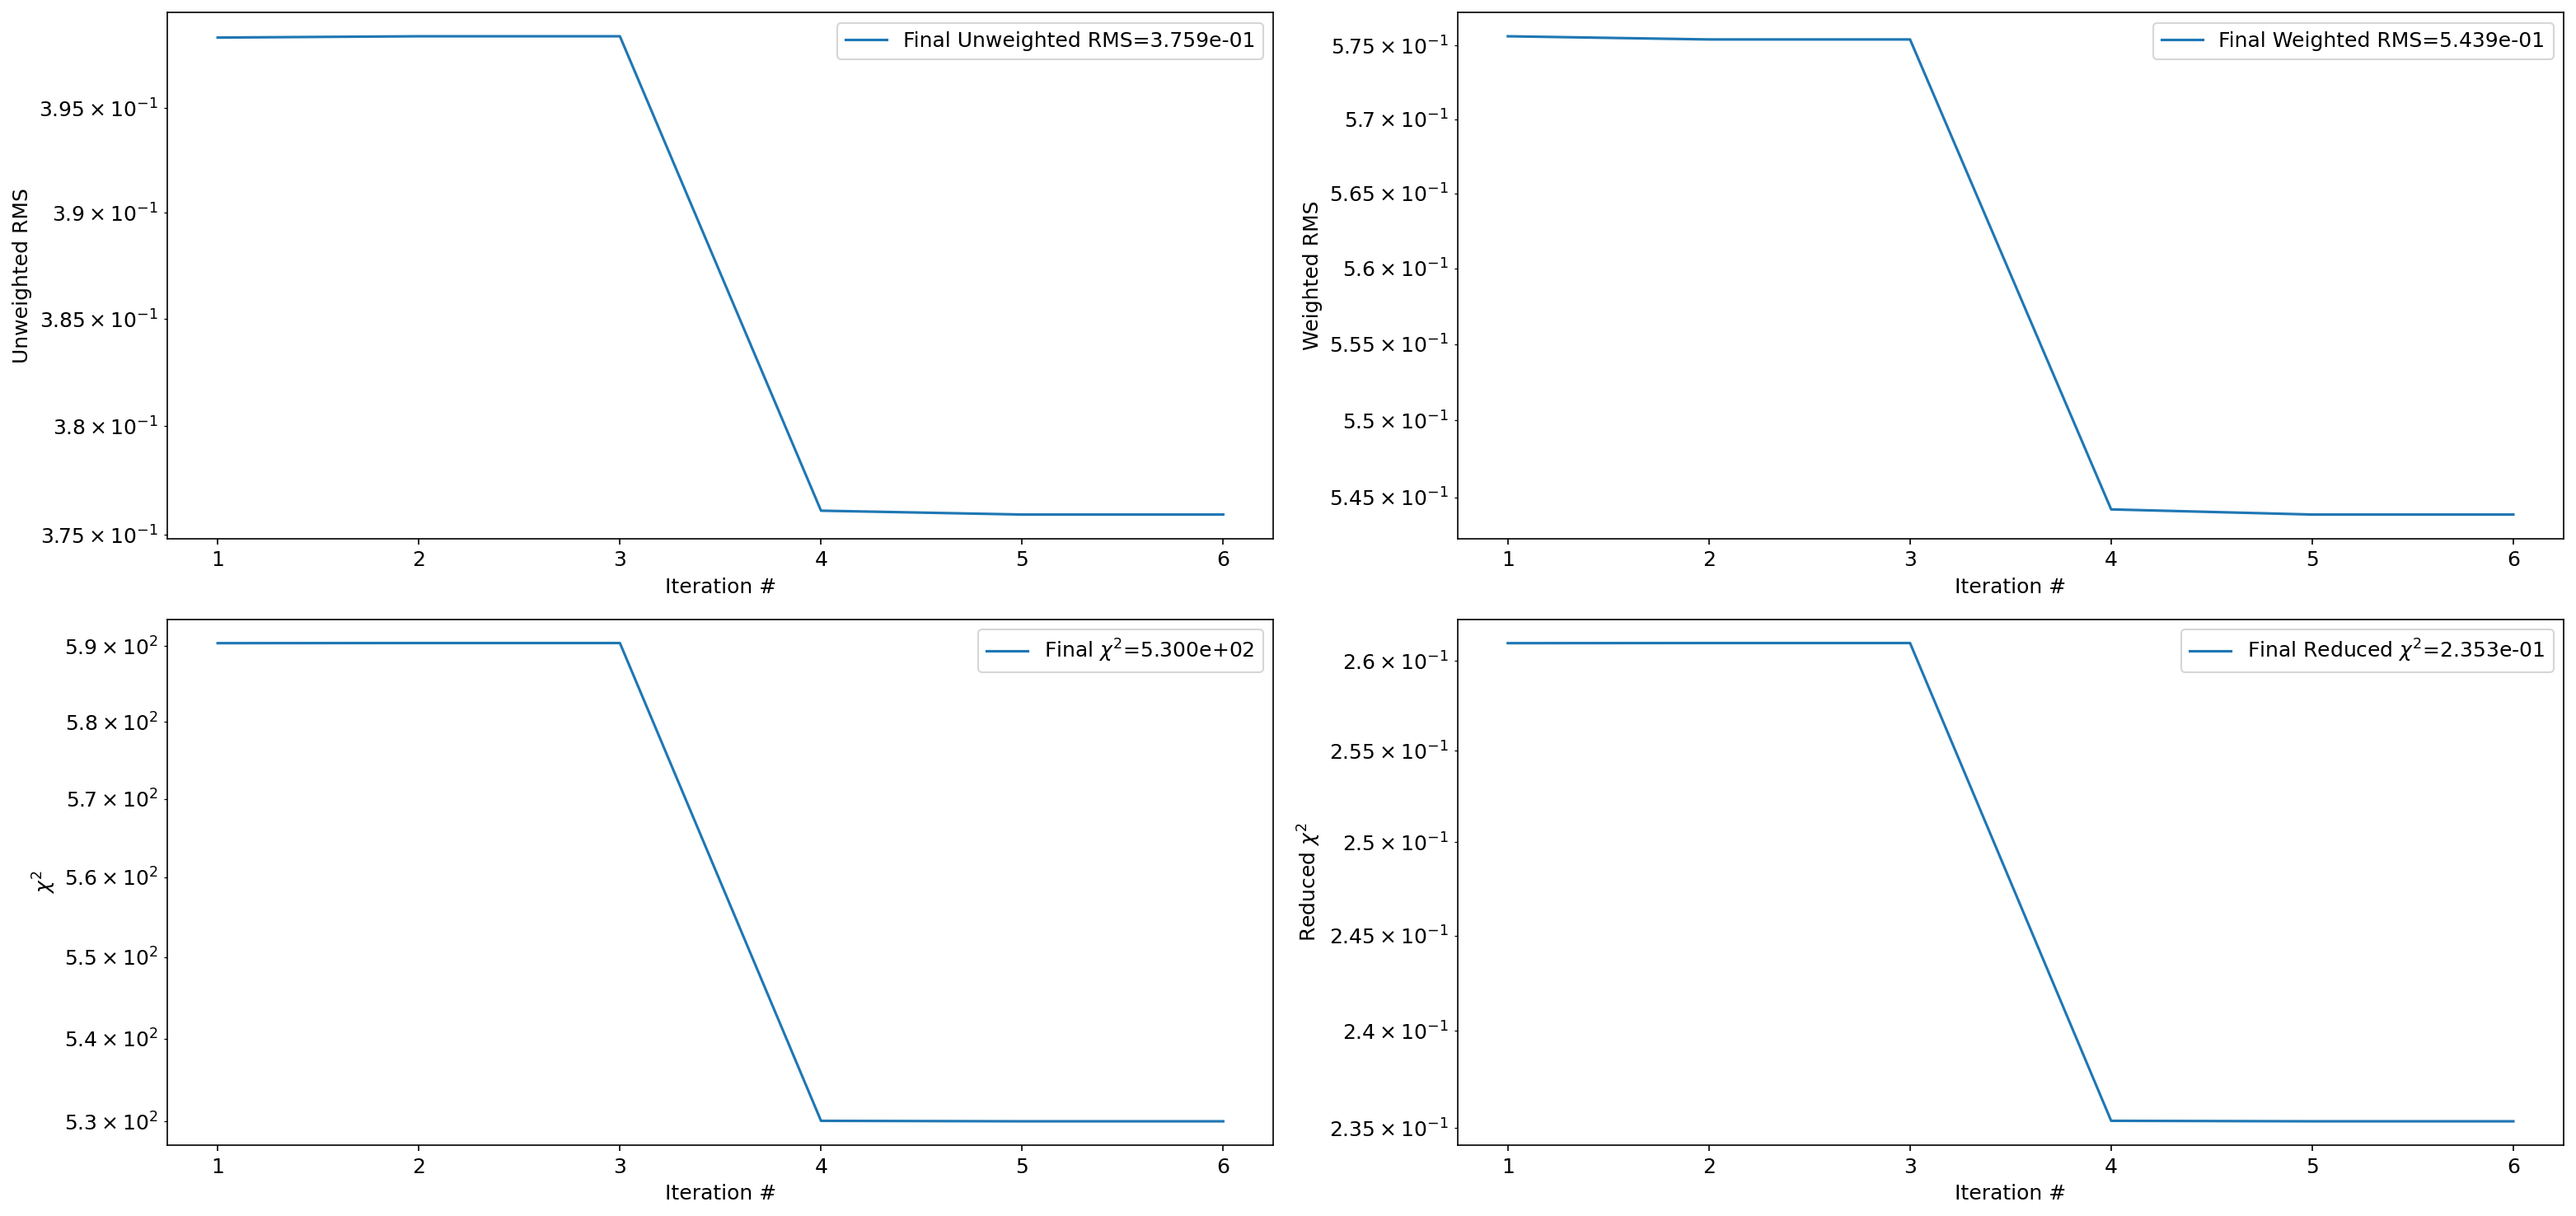

In [8]:
fit_sim.plot_summary(auto_close=True)

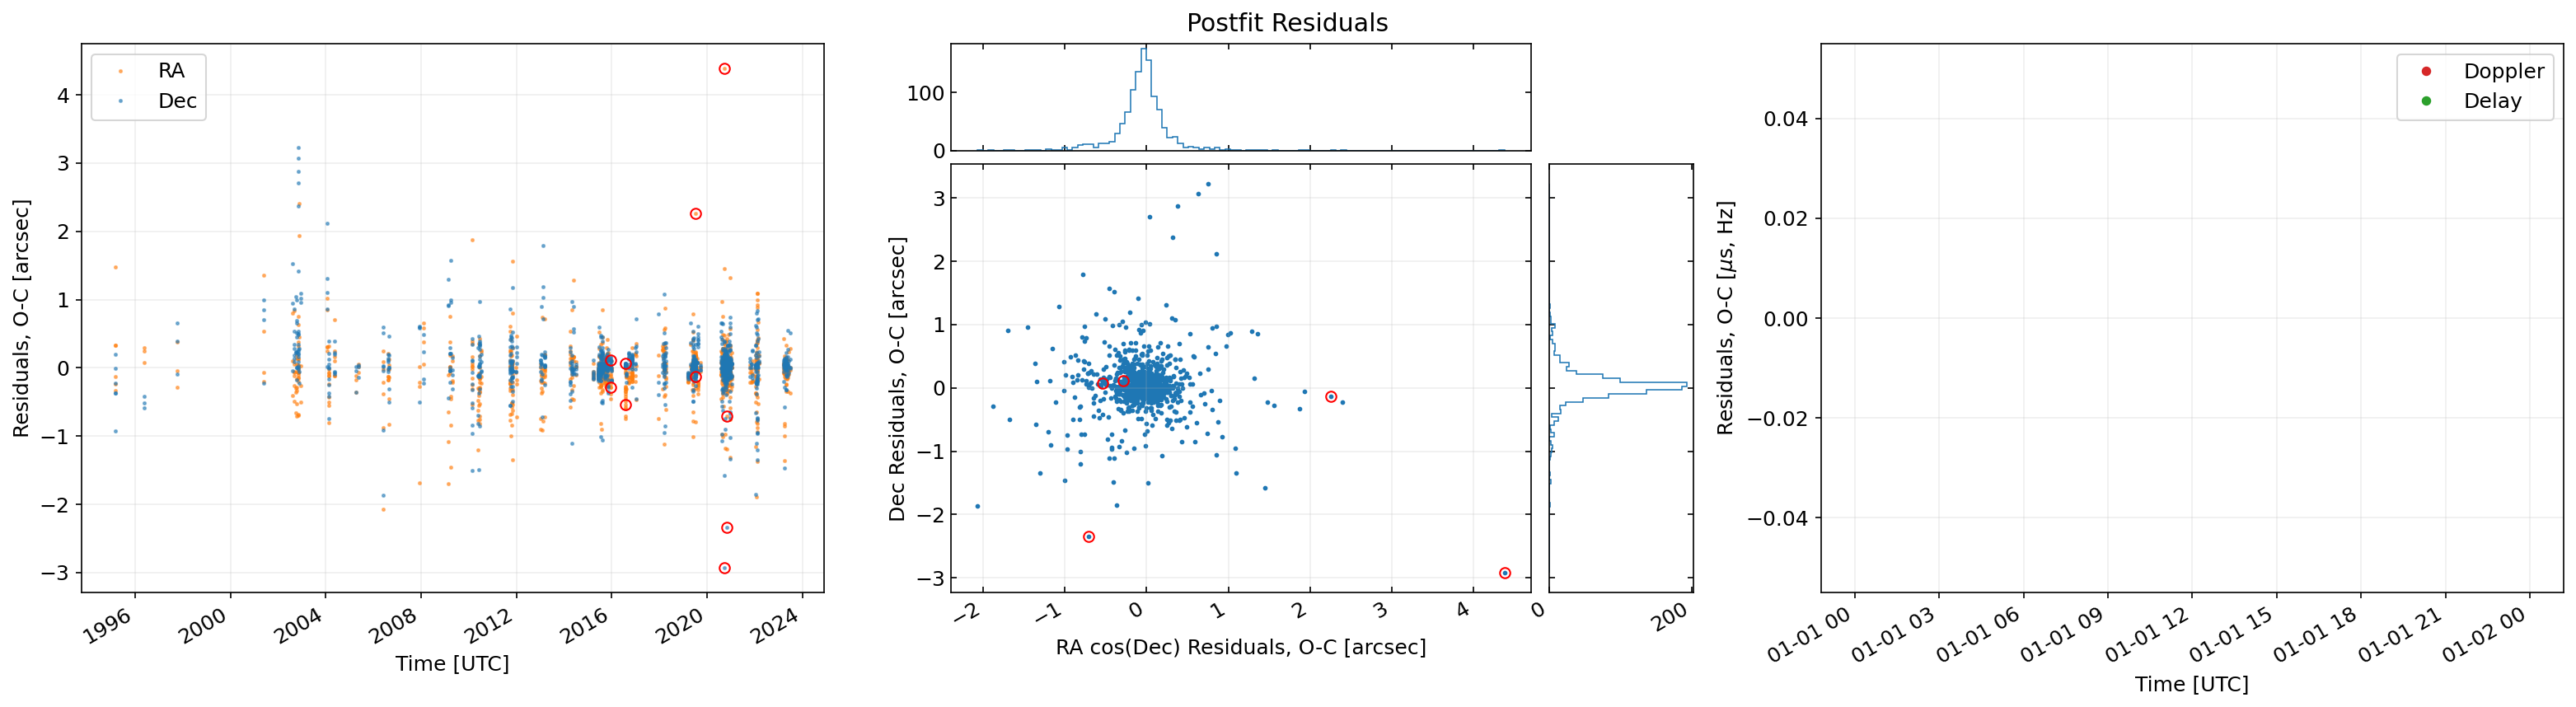

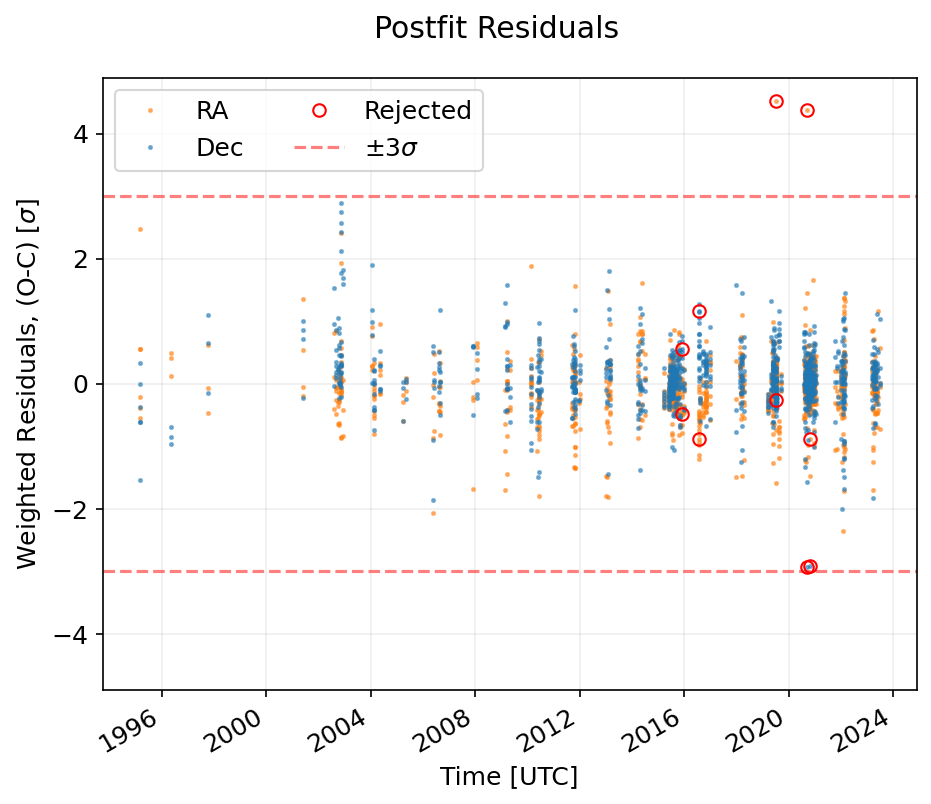

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.37
Mahalonobis distance between GRSS and JPL solution: 0.37
Bhattacharya distance between JPL and GRSS solution: 0.0004
Bhattacharya coefficient between JPL and GRSS solution: 0.9996


In [11]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90